<a href="https://colab.research.google.com/github/arunm917/CS6910-Assignment-2/blob/main/CS6910_Assignment_2_part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing packages and assigning directory

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import random
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from glob import glob
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from torch.nn.modules.pooling import MaxPool2d
import torch.optim as optim
from torchvision import models
# import wandb

In [ ]:
# API = 887362a2ceb2116d60b2d826763161b8361e55a1

In [ ]:
# wandb.login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/Othercomputers/My Computer/Courses/CS6910_2023/CS6910-Assignment-2/inaturalist_12K/train'
test_path = '/content/drive/Othercomputers/My Computer/Courses/CS6910_2023/CS6910-Assignment-2/inaturalist_12K/val'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!nvidia-smi

# Preprocessing dataset

In [ ]:
# Image transforms
train_transforms = transforms.Compose([
    # transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(224),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_data = ImageFolder(train_path, transform=train_transforms)
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
# Set a seed value for reproducibility
torch.manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])
test_dataset = ImageFolder(test_path, transform=test_transforms)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
dataset = DataLoader(train_dataset, shuffle=True, num_workers = 2)
dataiter = iter(dataset)
images, labels = next(dataiter)

In [ ]:
print(images.shape)
image_dim = images.shape[2]

torch.Size([1, 3, 224, 224])


## Creating val set with equal images from each class

In [ ]:
# Load the dataset
dataset = ImageFolder(train_path, transform=train_transforms)

#Create a dictionary to store the indices of each class
class_indices = {}
for i, (image, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

# Split each class into training and validation sets
train_indices = []
val_indices = []
for indices in class_indices.values():
    random.shuffle(indices)
    split = int(0.8 * len(indices))
    train_indices += indices[:split]
    val_indices += indices[split:]

# Create subsets for the training and validation sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

KeyboardInterrupt: ignored

In [ ]:
len(train_dataset)

7998

In [ ]:
# # Create train and validation data loaders
# test_dataset = ImageFolder(test_path, transform=test_transforms)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# test_dataset.size

In [ ]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

In [ ]:
# print(images.shape)
# print(images[20].shape)
# print(labels[20].item())

#Data visualization

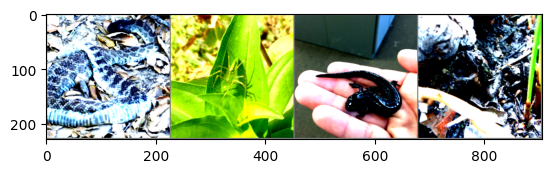

tensor([9, 2, 0, 0])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Getting a batch of images from the train loader
dataiter = iter(train_loader)
images_train, labels_train = next(dataiter)

# Get a batch of images from the test loader
dataiter = iter(test_loader)
images_test, labels_test = next(dataiter)

# Show a few images from the batch
imshow(torchvision.utils.make_grid(images_train))
print(labels_train)

# Resnet

In [ ]:
resnet = models.resnet50(pretrained = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]


In [ ]:
print(resnet)

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 10)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 2048])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_function = nn.CrossEntropyLoss()
la = optim.SGD(resnet.parameters(), lr=0.01)

In [ ]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 2)

In [ ]:
def accuracy(dataloader):
  total, correct_predictions = 0, 0
  for data in dataloader:
    X, Y = data
    X, Y = X.to(device), Y.to(device)
    Y_pred = resnet(X)
    _, pred = torch.max(Y_pred.data, 1)
    total += Y.size(0)
    correct_predictions += (pred == Y).sum().item()
    accuracy = (correct_predictions/total)*100
  return accuracy

In [ ]:
loss_batch = []
loss_epoch = []
epochs = 5
for epoch in tqdm(range(epochs)):
  for i, data in enumerate(train_loader, 0):
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      la.zero_grad()
      y_pred = resnet(images)

      loss = loss_function(y_pred, labels)
      loss.backward()
      la.step()

      loss_batch.append(loss.item())
  loss_epoch.append(loss.item())
  accuracy_val = accuracy(val_loader)
  accuracy_train = accuracy(train_loader)     
  print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, accuracy_val, accuracy_train ))
  #wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_training, 'epoch':epoch})
plt.plot(loss_epoch)
plt.show()

  0%|          | 0/5 [06:26<?, ?it/s]


KeyboardInterrupt: ignored

# WANDB

In [ ]:
sweep_configuration = {
  'method': 'grid',
  'name': 'sweep',
  'metric': {'goal': 'maximize', 'name': 'accuracy_val'},
  'parameters': {
      'batch_norm':{'values':['YES','NO']},
      'num_layers': {'values': [5]},
      'num_filters': {'values': [32]},
      'conv_filter_size': {'values': [5]},
      'dropout': {'values': [0.05,0.1,0.2]},
      'activation':{'values':['ReLU', 'GELU', 'LeakyReLU', 'SiLU', 'Mish']},
      'dense_neurons': {'values': [128]},
      'learning_rate': {'values': [1e-4,1e-5,1e-6]},
      'weight_decay': {'values': [0, 0.0005, 0.5]},
      'optimizer': {'values': ['Adam', 'NAdam','RAdam', 'AdamW', 'SGD']},
    } }

In [ ]:
def wandbsweeps():
  wandb.init(project = 'CS6910_Assignment_2')
  print('wandb initialize')
  wandb.run.name = (
        "bn"
        + str(wandb.config.batch_norm)
        + "nf"
        + str(wandb.config.num_filters)
        + "fs"
        + str(wandb.config.conv_filter_size)
        + "do"
        + str(wandb.config.dropout)
        + "lr"
        + str(wandb.config.learning_rate)
        + "opt"
        + wandb.config.optimizer
        + "af"
        + str(wandb.config.activation)
    )
  print('wandb run initialize')
  model = CNN(
    batch_norm = wandb.config.batch_norm,
    num_layers = wandb.config.num_layers,
    num_filters = wandb.config.num_filters, 
    conv_filter_size = wandb.config.conv_filter_size,
    dropout = wandb.config.dropout, 
    activation = wandb.config.activation,
    dense_neurons = wandb.config.dense_neurons).to(device)
  print('model')

  def accuracy(dataloader):
  total, correct_predictions = 0, 0
  for data in dataloader:
    X, Y = data
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    _, pred = torch.max(Y_pred.data, 1)
    total += Y.size(0)
    correct_predictions += (pred == Y).sum().item()
    accuracy = (correct_predictions/total)*100
  return accuracy
  
  ## Loss and optimizer ##  
  loss_cr = nn.CrossEntropyLoss()
  print('Loss')
  if wandb.config.optimizer == 'Adam':
    la = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'NAdam':
    la = optim.NAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay= wandb.config.weight_decay)
  elif wandb.config.optimizer == 'RAdam':
    la = optim.RAdam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'AdamW':
    la = optim.AdamW(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  elif wandb.config.optimizer == 'SGD':
    la = optim.SGD(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
  else:
      raise ValueError("Invalid optimizer type.")
    
  print('optim')
  loss_batch = []
  loss_epoch = []
  epochs = 5
  for i in tqdm(range(epochs)):
    epoch = i+1
    for j, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # print(images.size)
        la.zero_grad()
        y_pred = model(images)
        loss = loss_cr(y_pred, labels)
        loss.backward()
        la.step()
        loss_batch.append(loss.item())
    loss_epoch.append(loss.item())
    accuracy_val = accuracy(val_loader)
    accuracy_train = accuracy(train_loader)
    print('training loop')     
    print('Epoch: %d/%d, Validation acc: %0.2f, Train acc: %0.2f' % (epoch, epochs,accuracy_val, accuracy_train ))
    wandb.log({'loss_epoch': loss_epoch, 'accuracy_val':accuracy_val, 'accuracy_training':accuracy_train, 'epoch':epoch})

sweep_id = wandb.sweep(sweep= sweep_configuration, project = 'CS6910_Assignment_2')
wandb.agent(sweep_id, function = wandbsweeps)
# wandb.agent(sweep_id, function = wandbsweeps, count = 10)